# Convert postISRCCD into sources

 work with Weakly_2022_39
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022/10/31
- update : 2022/11/01


In [1]:
! eups list -s | grep LOCAL

atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2022_39/atmospec 	setup
drp_pipe              LOCAL:/home/d/dagoret/repos/repos_w_2022_39/drp_pipe 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/eups 	setup
summit_utils          LOCAL:/home/d/dagoret/repos/repos_w_2022_39/summit_utils 	setup


In [2]:
! eups list -s lsst_distrib

   g0b29ad24fb+a10408d0bf 	current w_2022_39 setup


In [3]:
import lsst.daf.butler as dafButler
import lsst.summit.utils.butlerUtils as butlerUtils
import lsst.daf.base as dafBase

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

# Pipeline tasks from DP0.2
#from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
#from lsst.meas.algorithms.detection import SourceDetectionTask
#from lsst.meas.deblender import SourceDeblendTask
#from lsst.meas.base import SingleFrameMeasurementTask

# fromm StackClub on Britter-Fatter
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
import lsst.meas.extensions.shapeHSM
from lsst.pipe.tasks.calibrate import CalibrateTask, CalibrateConfig

In [6]:
#Set the matplotlib plot color table.
plt.style.use('tableau-colorblind10')

In [7]:
# Let us also set `lsst.afw.display` to use the `matplotlib` backend:
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [8]:
repo =  "/sdf/group/rubin/repo/main"
#repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

## Give the collection

In [9]:
my_collection = "u/dagoret/spectro/noflat/empty~holo4/20211103"

In [10]:
#butler = butlerUtils.makeDefaultLatissButler(extraCollections=[my_collection])

## Config

In [11]:
# path index for each month
DATE="20211103"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"

In [12]:
datasetRefs = registry.queryDatasets(datasetType='icSrc_schema', collections=my_collection, where= "instrument='LATISS'")
#icSrc_schema = butler.get('icSrc_schema')

## postISRCCD

In [13]:
datasetRefs = registry.queryDatasets(datasetType='postISRCCD', collections=my_collection, where= "instrument='LATISS'")

In [14]:
all_dataId = []
all_postisrccd  = []
all_exposures = []



for i, ref in enumerate(datasetRefs):
   
    print(f"========({i})================datasetType = postISRCCD ============================================")
    print("fullId..................:",ref.dataId.full)
    print("exposure................:",ref.dataId["exposure"])
    print("band....................:",ref.dataId["band"])
    print("physical filter.........:",ref.dataId["physical_filter"])
    print("run.....................:",ref.run)
    the_exposure = ref.dataId["exposure"]
    the_day_obs = ref.dataId["exposure"]//100_000
    the_seq_num = ref.dataId["exposure"]- the_day_obs*100_000    
    the_dataId = {'day_obs': the_day_obs,'seq_num':the_seq_num,'detector':0}
    print(the_dataId)
    #spec       = butler.get('spectraction',the_dataId)
    postisrccd = butler.get('postISRCCD', exposure=the_exposure, detector=0, collections=my_collection, instrument='LATISS')
    all_dataId.append(the_dataId) 
    all_exposures.append(the_exposure)
    all_postisrccd.append(postisrccd)
    if i > 0:
        break

========(0)================datasetType = postISRCCD ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', exposure: 2021110300459}
exposure................: 2021110300459
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/spectro/noflat/empty~holo4/20211103/20221031T154824Z
{'day_obs': 20211103, 'seq_num': 459, 'detector': 0}
========(1)================datasetType = postISRCCD ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', exposure: 2021110300465}
exposure................: 2021110300465
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/spectro/noflat/empty~holo4/20211103/20221031T155742Z
{'day_obs': 20211103, 'seq_num': 465, 'detector': 0}


<Figure size 600x600 with 0 Axes>

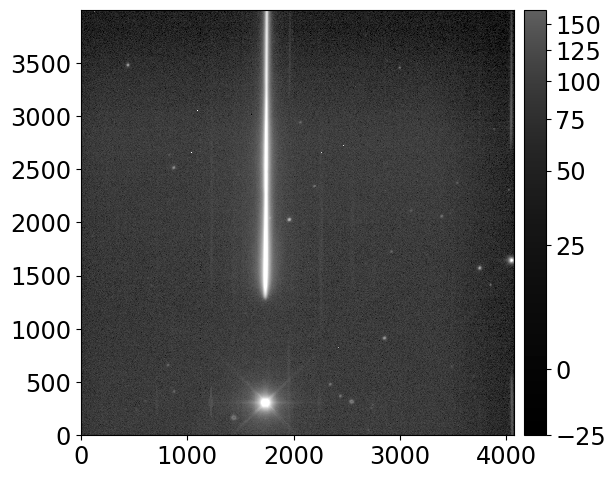

In [15]:
# Plot the calexp we just retrieved
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(postisrccd.image)

<Figure size 600x600 with 0 Axes>

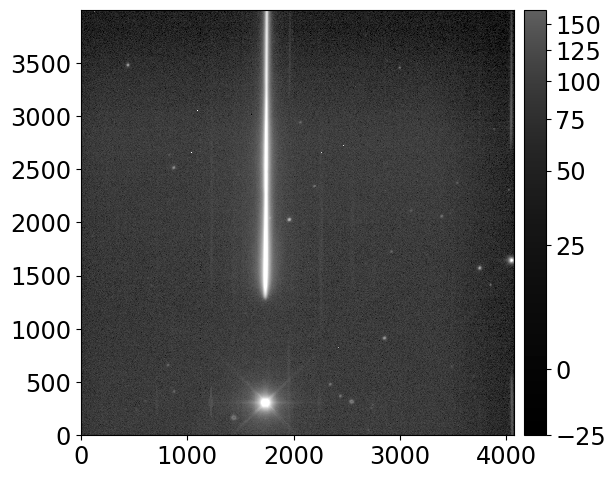

In [16]:
# Plot the calexp we just retrieved
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(postisrccd.maskedImage.image)

In [17]:
ccdshape = postisrccd.image.array.shape
ccdshape 

(4000, 4072)

In [18]:
ccd_ymax=ccdshape[0]
ccd_xmax=ccdshape[1]

In [19]:
postisrccd.image.array.flatten()

array([28.209455, 10.509457, 39.059456, ..., 14.697332, 16.760708,
       14.866823], dtype=float32)

Text(0.5, 1.0, 'distribution of pixel value in postISRCCD')

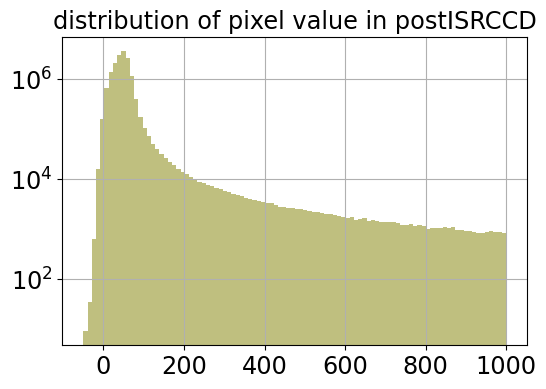

In [20]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
ax.hist(postisrccd.image.array.flatten(),bins=100,range=(-50,1000),alpha=0.5,facecolor='blue')
ax.hist(postisrccd.maskedImage.image.array.flatten(),bins=100,range=(-50,1000),alpha=0.5,facecolor="yellow")
ax.set_yscale('log')
ax.grid()
ax.set_title("distribution of pixel value in postISRCCD")

# Detection of Sources

## Step 2: Perform image characterization and initial measurement
We now perform a base-level characterization of the image using the stack. We set some configuration settings which are specific to our sestup which has a very small optical PSF, setting a PSF size and turning off some other aspects such as cosmic ray rejection because of this.

In [21]:
#from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
#import lsst.meas.extensions.shapeHSM

# first set a few configs that are specific to our beam simulator data
charConfig = CharacterizeImageConfig()
#this set the fwhm of the simple PSF to that of optics
charConfig.installSimplePsf.fwhm = 10
charConfig.doMeasurePsf = False
charConfig.doApCorr = False # necessary
charConfig.repair.doCosmicRay = False  
# we do have some cosmic rays, but we also have subpixel mask features and an undersampled PSF
charConfig.detection.background.binSize = 10   # worth playing around with
#charConfig.background.binSize = 50
charConfig.detection.minPixels = 10   # also worth playing around with

# Add the HSM (Hirata/Seljak/Mandelbaum) adaptive moments shape measurement plugin
charConfig.measurement.plugins.names |= ["ext_shapeHSM_HsmSourceMoments"]
# to configure hsm you would do something like
# charConfig.measurement.plugins["ext_shapeHSM_hsmSourceMoments"].addFlux = True
# (see sfm.py in meas_base for all the configuration options for the measurement task)

# Turn off the summary statistic calculation for these spot images.
# In the future there may be a specialized task for spot images.
charConfig.doComputeSummaryStats = False

charTask = CharacterizeImageTask(config=charConfig)

#charTask.run?
# use charTask.run instead of characterize for v16.0+22
# could also perform similar functions with processCcdTask.run()

/tmp/ipykernel_15896/2284028487.py:24: FutureWarning: Config field doComputeSummaryStats is deprecated: This subtask has been moved to CalibrateTask with DM-30701.
  charConfig.doComputeSummaryStats = False


In [22]:
# Display which plugins are being used for measurement
charConfig.measurement.plugins.active 

[lsst.meas.base.gaussianFlux.GaussianFluxConfig(doMeasure=True, background=0.0),
 lsst.meas.extensions.shapeHSM.hsmMomentsControl.HsmSourceMomentsConfig(doMeasure=True, addFlux=False, badMaskPlanes=['BAD', 'SAT'], roundMoments=False),
 lsst.meas.base.psfFlux.PsfFluxConfig(doMeasure=True, badMaskPlanes=[]),
 lsst.meas.base.pixelFlags.PixelFlagsConfig(doMeasure=True, masksFpAnywhere=[], masksFpCenter=[]),
 lsst.meas.base.apertureFlux.ApertureFluxConfig(doMeasure=True, maxSincRadius=10.0, radii=[3.0, 4.5, 6.0, 9.0, 12.0, 17.0, 25.0, 35.0, 50.0, 70.0], shiftKernel='lanczos5'),
 lsst.meas.base.sdssCentroid.SdssCentroidConfig(doMeasure=True, binmax=16, doFootprintCheck=True, maxDistToPeak=-1.0, peakMin=-1.0, wfac=1.5)]

Detected  49  objects 


(0.0, 4000.0)

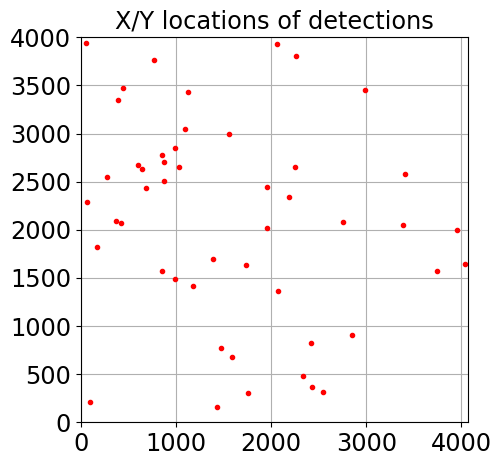

In [23]:
charResult = charTask.run(postisrccd) # charTask.run(exposure) stack v16.0+22
print("Detected ",len(charResult.sourceCat)," objects ")
fig=plt.figure(figsize=(5,5))
plt.title('X/Y locations of detections')
plt.plot(charResult.sourceCat['base_SdssCentroid_x'],charResult.sourceCat['base_SdssCentroid_y'],'r.')
plt.grid()
plt.xlim(0,ccd_xmax)
plt.ylim(0,ccd_ymax)

This figure illustrates the centroids of detections made during characterization. Note that not all objects have been detected in this first round.

In [24]:
charResult.sourceCat.asAstropy()

id,coord_ra,coord_dec,parent,calib_psf_candidate,calib_psf_used,calib_psf_reserved,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_PsfFlux_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_PsfFlux_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_PsfFlux_flag_badCentroid_badError,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_badError,slot_Centroid_flag_badError,ext_shapeHSM_HsmSourceMoments_x,slot_Shape_x,ext_shapeHSM_HsmSourceMoments_y,slot_Shape_y,ext_shapeHSM_HsmSourceMoments_xx,slot_Shape_xx,ext_shapeHSM_HsmSourceMoments_yy,slot_Shape_yy,ext_shapeHSM_HsmSourceMoments_xy,slot_Shape_xy,ext_shapeHSM_HsmSourceMoments_flag,base_GaussianFlux_flag_badShape,slot_Shape_flag,ext_shapeHSM_HsmSourceMoments_flag_no_pixels,base_GaussianFlux_flag_badShape_no_pixels,slot_Shape_flag_no_pixels,ext_shapeHSM_HsmSourceMoments_flag_not_contained,base_GaussianFlux_flag_badShape_not_contained,slot_Shape_flag_not_contained,ext_shapeHSM_HsmSourceMoments_flag_parent_source,base_GaussianFlux_flag_badShape_parent_source,slot_Shape_flag_parent_source,ext_shapeHSM_HsmSourceMoments_flag_galsim,base_GaussianFlux_flag_badShape_galsim,slot_Shape_flag_galsim,ext_shapeHSM_HsmSourceMoments_flag_edge,base_GaussianFlux_flag_badShape_edge,slot_Shape_flag_edge,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_12_0_instFlux,slot_ApFlux_instFlux,slot_CalibFlux_instFlux,base_CircularApertureFlu

# Calibration and Photometry

## Step 3: Further image calibration and measurement
This builds on the exposure output from characterization, using the new mask plane as well as the source catalog. Similar to the characterization, we turn off some processing which is suited to our particular setup. For this dataset a calibrate task is almost unncessary (as it is not on-sky data and we don't have a reference catalog), however, it does provide a background-subtracted image and for completeness it is included here. The steps in calibration that are turned on/off can be seen by printing the calibration config object.

In [25]:
#from lsst.pipe.tasks.calibrate import CalibrateTask, CalibrateConfig

calConfig = CalibrateConfig()
calConfig.doAstrometry = False
calConfig.doPhotoCal = False
calConfig.doApCorr = False
calConfig.doDeblend = False   # these are well-separated objects, deblending adds time & trouble
# these images should have a uniform background, so measure it
#  on scales which are larger than the objects
calConfig.detection.background.binSize = 50
calConfig.detection.minPixels = 5
calConfig.measurement.plugins.names |= ["ext_shapeHSM_HsmSourceMoments"]
# to configure hsm you would do something like
#charConfig.measurement.plugins["ext_shapeHSM_hsmSourceMoments"].addFlux = True
calConfig.doComputeSummaryStats = True # no summary stats

calTask = CalibrateTask(config= calConfig, icSourceSchema=charResult.sourceCat.schema)

#calTask.run? # for stack v16.0+22 
calTask.run?

Signature:
calTask.run(
    exposure,
    exposureIdInfo=None,
    background=None,
    icSourceCat=None,
)
Docstring:
Calibrate an exposure.

Parameters
----------
exposure : `lsst.afw.image.ExposureF`
    Exposure to calibrate.
exposureIdInfo : `lsst.obs.baseExposureIdInfo`, optional
    Exposure ID info. If not provided, returned SourceCatalog IDs will not
    be globally unique.
background : `lsst.afw.math.BackgroundList`, optional
    Initial model of background already subtracted from exposure.
icSourceCat : `lsst.afw.image.SourceCatalog`, optional
    SourceCatalog from CharacterizeImageTask from which we can copy some fields.

Returns
-------
result : `lsst.pipe.base.Struct`
    Results as a struct with attributes:

    ``exposure``
       Characterized exposure (`lsst.afw.image.ExposureF`).
    ``sourceCat``
       Detected sources (`lsst.afw.table.SourceCatalog`).
    ``outputBackground``
       Model of subtracted background (`lsst.afw.math.BackgroundList`).
    ``astromMatc

In [26]:
# for stack v16.0+22, change to calTask.run(charResult.exposure)
calResult = calTask.run(charResult.exposure, background=charResult.background,
                              icSourceCat = charResult.sourceCat)


print("Detected ",len(calResult.sourceCat)," objects ")

Detected  221  objects 


In [27]:
mytable = calResult.sourceCat.asAstropy()
mytable

id,coord_ra,coord_dec,parent,calib_detected,calib_psf_candidate,calib_psf_used,calib_psf_reserved,sky_source,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_par

### remove row with nan

In [28]:
# remove row with nan
has_nan = np.zeros(len(mytable), dtype=bool)
for col in mytable.itercols():
    if col.info.dtype.kind == 'f':
        has_nan |= np.isnan(col)
mytable_no_nan = mytable[~has_nan]

### rename the columns

In [29]:
# rename the columns
mytable_no_nan.rename_column('base_NaiveCentroid_x', 'Xpix')
mytable_no_nan.rename_column('base_NaiveCentroid_y', 'Ypix')
mytable_no_nan.rename_column('base_Blendedness_abs_child_instFlux', 'abs_chld_instFlux')
mytable_no_nan.rename_column('base_Blendedness_abs_parent_instFlux','abs_paren_instFlux')

(0.0, 4000.0)

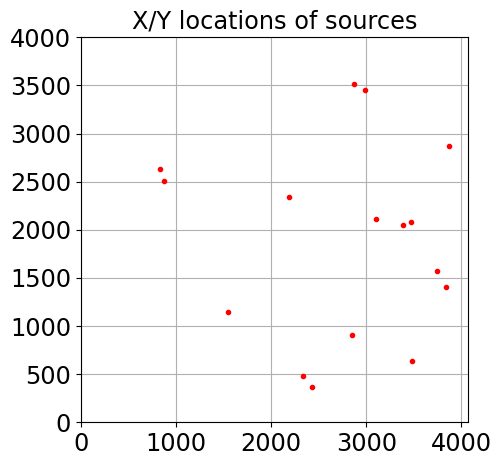

In [30]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(1,1,1)
ax.set_title('X/Y locations of sources')
ax.plot(mytable_no_nan['Xpix'],mytable_no_nan['Ypix'],'r.')
ax.grid()
ax.set_xlim(0,ccd_xmax)
ax.set_ylim(0,ccd_ymax)

In [31]:
df_table = mytable_no_nan.to_pandas()
df_table.columns

Index(['id', 'coord_ra', 'coord_dec', 'parent', 'calib_detected',
       'calib_psf_candidate', 'calib_psf_used', 'calib_psf_reserved',
       'sky_source', 'Xpix',
       ...
       'base_LocalPhotoCalibErr', 'base_LocalWcs_flag',
       'base_LocalWcs_CDMatrix_1_1', 'base_LocalWcs_CDMatrix_1_2',
       'base_LocalWcs_CDMatrix_2_1', 'base_LocalWcs_CDMatrix_2_2',
       'detect_isPrimary', 'base_ClassificationExtendedness_value',
       'base_ClassificationExtendedness_flag', 'base_FootprintArea_value'],
      dtype='object', length=288)

In [32]:
df = df_table[['id', 'coord_ra', 'coord_dec', 'Xpix','Ypix','abs_chld_instFlux'	,'abs_paren_instFlux']]
df

,id,coord_ra,coord_dec,Xpix,Ypix,abs_chld_instFlux,abs_paren_instFlux
0,12,1.510130,-0.563972,2432.993317,365.016924,106265.039866,106265.039866
1,16,1.510073,-0.563925,2337.996199,476.001635,121169.724625,121169.724625
2,19,1.510687,-0.563800,3476.978856,640.938890,32335.204833,32335.204833
3,26,1.510329,-0.563703,2846.006750,908.993812,376733.309820,376733.309820
4,28,1.509605,-0.563650,1544.033540,1142.953559,24901.989343,24901.989343
5,31,1.510847,-0.563429,3841.019240,1409.957118,64877.781231,64877.781231
6,41,1.510784,-0.563360,3740.016618,1567.993269,590321.563767,590321.563767
7,58,1.510565,-0.563151,3383.984781,2053.985284,105584.434579,105584.434579
8,61,1.510608,-0.563134,3466.967400,2082.050870,21445.474154,21445.474154
9,64,1.510405,-0.563138,3098.033523,2108.056988,52053.675664,52053.675664


In [33]:
the_max = df['abs_paren_instFlux'].describe()['max']
the_min = df['abs_paren_instFlux'].describe()['min']

Text(0, 0.5, 'number of sources')

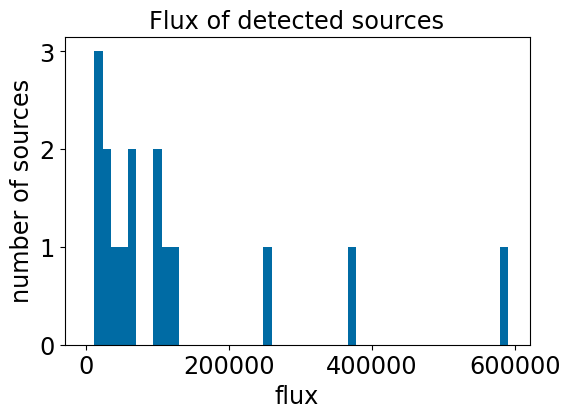

In [34]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
ax.hist(df['abs_paren_instFlux'].values,bins=50,range=(0,the_max));
ax.set_title("Flux of detected sources")
ax.set_xlabel('flux')
ax.set_ylabel('number of sources')